In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

In [3]:
train_dataset = MNIST(True)
test_dataset = MNIST(False)

In [4]:
train_x, train_y = train_dataset.data.numpy(), train_dataset.targets
test_x, test_y = test_dataset.data.numpy(), test_dataset.targets
train_y2 = to_one_hot(train_y, 10).numpy()
test_y2 = to_one_hot(test_y, 10).numpy()
train_y = train_y.numpy()
test_y = test_y.numpy()

In [5]:
train_data = FromNumpy(train_x[:, None, :, :], [train_y2, train_y], batch_size=256)
test_data = FromNumpy(test_x[:, None, :, :], [test_y2, test_y], batch_size=256)

In [6]:
class Orthogonal(nn.Module):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, w1, w2):
        return self.alpha * torch.matmul(w1, w2.t()).abs().mean()

In [7]:
model = builder([
    SpectralNorm(nn.Conv2d(1, 20, 5, 1), power_iterations=5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    SpectralNorm(nn.Conv2d(20, 50, 5, 1), power_iterations=5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    Flatten(),
    Auxiliary(builder([
        Reg(NoisyLinear(4*4*50, 128), 'orth'),
        nn.ReLU(),
        Reg(NoisyLinear(128, 10), 'orth2'),
        nn.Sigmoid()
    ])),
    Reg(NoisyLinear(4*4*50, 128), 'orth'),
    nn.ReLU(),
    Reg(NoisyLinear(128, 10), 'orth2'),
    nn.LogSoftmax(1)
])

In [8]:
runner = Runner(model, train_data, test_data, 'adam', ['bce', 'nll'], reg_fn={'orth': Orthogonal(), 'orth2': Orthogonal()}, fp16=False)

In [9]:
runner.fit(3, cycle='sc')

  Epochs    train_loss    train_acc      val_loss      val_acc    
    1*        2.7294        0.6873        0.2177        0.9489    


    2         0.2644        0.9369        0.0994        0.9744    


    3         0.1330        0.9678        0.0572        0.9853    



In [10]:
runner.validate()

0.05761747530195862 0.9853


In [11]:
model = runner.model

tensor(8.)
tensor([[3.8262e-02, 2.6039e-04, 8.4746e-01, 1.0437e-02, 4.2330e-03, 2.3730e-02,
         7.7053e-03, 4.5746e-03, 6.1553e-02, 1.7891e-03]], device='cuda:0',
       grad_fn=<ExpBackward>)
tensor([[9.3682e-03, 1.0580e-02, 7.9543e-01, 2.9239e-03, 1.3784e-03, 3.8830e-02,
         9.7326e-03, 1.8439e-02, 4.8769e-02, 3.6781e-04]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[3.5844e-04, 2.7550e-06, 6.7409e-01, 3.0515e-05, 5.8349e-06, 9.2142e-04,
         7.4993e-05, 8.4351e-05, 3.0019e-03, 6.5806e-07]], device='cuda:0',
       grad_fn=<MulBackward0>)


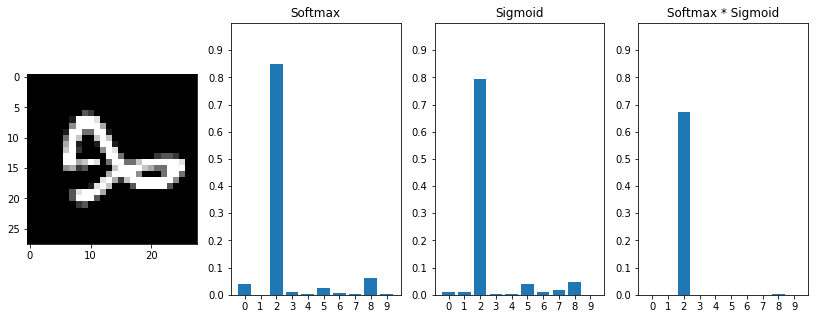

In [12]:
data = next(iter(test_data))
x = data[0][0]
x = x[None, :, :, :]
print(data[2][0])

x = x.permute(0,1,3,2)

out1 = model(x.cuda()).exp()
out2 = get_aux_out(model)[0]
print(out1)
print(out2)
print((out1*out2))

import matplotlib.pyplot as plt
fig, arr = plt.subplots(1, 4, figsize=(14, 5))
arr[0].imshow(x.numpy()[0][0], cmap='gray')
arr[1].set_title('Softmax')
arr[1].set_xticks(range(10))
arr[1].set_yticks([i/10 for i in range(10)])
arr[1].set_ylim(0, 1)
arr[1].bar(range(10), out1.detach().cpu().numpy()[0])
arr[2].set_title('Sigmoid')
arr[2].set_xticks(range(10))
arr[2].set_yticks([i/10 for i in range(10)])
arr[2].set_ylim(0, 1)
arr[2].bar(range(10), out2.detach().cpu().numpy()[0])
arr[3].set_title('Softmax * Sigmoid')
arr[3].set_xticks(range(10))
arr[3].set_yticks([i/10 for i in range(10)])
arr[3].set_ylim(0, 1)
arr[3].bar(range(10), ((out1*out2)).detach().cpu().numpy()[0])
plt.show()


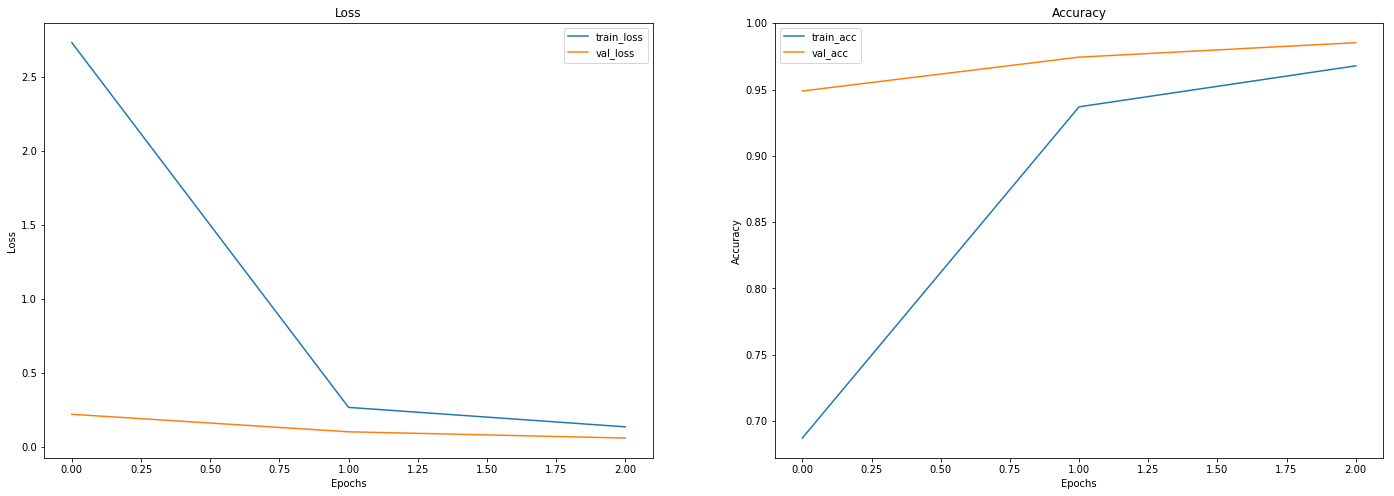

In [13]:
runner.history()